<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='40%'></img>

<br>

<a href="./00_index.ipynb"><< Index </a><br>
<a href="./12_sentinel3_nrt_slstr_aod_Californian_fires.ipynb"><< 12 - Sentinel-3 NRT SLSTR AOD - Californian Fires </a><span style="float:right;"><a href="./22_sentinel3_nrt_slstr_aod_exercise.ipynb">22 - Sentinel-3 NRT SLSTR AOD - Exercise >></a></span>

<div class="alert alert-block alert-success">
<b>EXERCISE WORKBOOK</b></div>

# Sentinel-3 Near Real Time SLSTR Fire Radiative Power (FRP)

This notebook is an `exercise workbook`, where you can practise the data handling with Sentinel-3 Near Real Time SLSTR Fire Radiative Power (FRP) data. The exercises base on the workflow introduced in the notebook [Sentinel-3 NRT SLSTR FRP - Californian Fires](./11_sentinel3_nrt_slstr_frp_Californian_fires.ipynb). We highly recommend that  you go through this notebook before you do this exercise workbook.

The exercise example is based on Sentinel-3 NRT SLSTR FRP data capturing the Siberian fires sensed on 27 June 2020. As a comparison, you see below the Sentinel-3 OLCI Red Green Blue composites for the same day, which clearly shows the smoke plumes in Siberia resulting from the fires.

<br>


<div style='text-align:center;'>
<figure><img src='./img/s3_olci_0727.png' width='80%'/>
    <figcaption><i>RGB composites of Sentinel-OLCI Level 1 data on 27 June 2020</i></figcaption>
</figure>
</div>
   

<hr>

### How it works

This exercise workbook consists of two types of exercises:

#### Coding assignments
Coding assignments ask you to fill an empty code cell with code. Code exercises base on the notebook [Sentinel-3 SLSTR FRP - Californian fires](./11_sentinel3_slstr_frp_Californian_fires.ipynb).

You recognize `coding assignments` as the yellow-coloured boxes.

<div class="alert alert-block alert-warning">
<b>Coding assignment</b>
</div>

#### Questions

Questions ask you to reflect on a result and output. `Questions` are provided as green-coloured boxes.

<div class="alert alert-block alert-success">
<b>Question</b>
</div>

<hr>

### Outline
* [1 - Load Sentinel-3 SLSTR FRP data](#load_s3_frp)
* [2 - Load, mask and regrid FRP computed from MWIR channel (3.7 um)](#load_mwir)

<hr>

#### Load required libraries

In [1]:
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as pltfacebook
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#### Load helper functions

In [2]:
from ipynb.fs.full.functions import generate_masked_array, visualize_s3_frp, slstr_frp_gridding

<hr>

#  Example: Siberian fires - June 2020

## <a id='load_s3_frp'></a>Load Sentinel-3 NRT SLSTR FRP data

Sentinel-3 NRT SLSTR FRP data are disseminated  in `netCDF` format. The first step is to load the data file with xarray's `open_dataset` function.


#### Load `Sentinel-3 NRT SLSTR FRP` data with xarray's `open_dataset()` function

Once the data file is loaded, you see that the data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are three variables of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW]
- `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW]
- `FLAG_SWIR_SAA` - Flag values to filter out South Atlantic ANomalies (SAA) & other transient / spurious events, only applicable to FRP SWIR

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Load the data file `FRP_in_Siberia_202000627.nc` under the directory `./eodata/sentinel3/frp/` with the xarray function `xr.open_dataset()` and call the Dataset `frp_xr`. 
</div>

In [3]:
# Enter your solution here







In [4]:
frp_dir = './eodata/'
frp_xr = xr.open_dataset(frp_dir+'FRP_in_Siberia_202000627.nc')
frp_xr

<xarray.Dataset>
Dimensions:                 (columns: 1500, fires: 1108, rows: 2000)
Dimensions without coordinates: columns, fires, rows
Data variables:
    i                       (fires) int16 ...
    j                       (fires) int32 ...
    time                    (fires) datetime64[ns] ...
    latitude                (fires) float64 ...
    longitude               (fires) float64 ...
    FRP_MWIR                (fires) float64 ...
    FRP_uncertainty_MWIR    (fires) float64 ...
    transmittance_MWIR      (fires) float64 ...
    FRP_SWIR                (fires) float64 ...
    FRP_uncertainty_SWIR    (fires) float64 ...
    FLAG_SWIR_SAA           (fires) int16 ...
    transmittance_SWIR      (fires) float64 ...
    confidence              (fires) float64 ...
    classification          (fires) uint8 ...
    S7_Fire_pixel_radiance  (fires) float32 ...
    F1_Fire_pixel_radiance  (fires) float32 ...
    used_channel            (fires) uint8 ...
    Radiance_window         (fir

<br>

<div class="alert alert-block alert-success">
<b>Question:</b><br>
   Can you identify the dimensions of the dataset? What data variables are available in the data file?
</div>

<br>

#### Load `latitude` and `longitude` information

You can already load the `latitude` and `longitude` information, which will be required for the regridding process.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Load the `latitude` and `longitude` variables from the xarray Dataset `frp_xr` above and call them `lat_frp` and `lon_frp` respectively.

<br>

Print both variables.
</div>

In [5]:
# Enter your solution here







In [6]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lat_frp

<xarray.DataArray 'latitude' (fires: 1108)>
array([53.275708, 53.269671, 55.355927, ..., 67.347698, 67.341288, 67.359559])
Dimensions without coordinates: fires
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0

<br>

#### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `gridding` process. For example the sampling size of the gridded FRP values or the geographical extent.

In [7]:
sampling_lat_FRP_grid = 0.25        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.25        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 40.         # Max Integrated FRP value, for plots


lat_min               = 50.        # Minimum latitude for mapping plot [deg N]
lat_max               = 72.        # Maximum latitude for mapping plot [deg N]
lon_min               = 120.        # Minimum lonitude for mapping plot [deg E]
lon_max               = 170.        # Maximum lonitude for mapping plot [deg E]

<br>

Now, let us go through the three different variables (`MWIR`, `SWIR` and `SWIR with SAA filtered out`) and let us load, mask, regrid and visualize them.

<br>

## <a id='load_mwir'></a>Load, mask and regrid `FRP computed from MWIR channel (3.7 um)`

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. You, see that the variable contains 1108 fire entries.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Load the `FRP_MWIR` variable from the xarray Dataset `frp_xr` above and call it `frp_mwir`.

<br>

Print the variable.
</div>

In [8]:
# Enter your solution






In [9]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (fires: 1108)>
array([ 8.712728,  3.450277, 27.888621, ...,  3.480033,  3.40337 ,  2.624291])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

<br>

<div class="alert alert-block alert-success">
<b>Question:</b><br>

What is the variable's `long_name`?
</div>

The `long_name` of the `FRP_MWIR` variable is `Fire radiative power computed from MWIR channels (S7 and F1)`.

<br>

The next step is to extract (mask) only the right FRP pixels. Valid pixels are different to -1.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Generate a masked array and mask out pixels with a value of -1. You can use the function [generate_masked_array](./functions.ipynb#generate_masked_array) to extract the right pixels.

<br>

**HINT:** With `?generate_masked_array` you can see the function's docstring and which keyword arguments it takes.
</div>

In [10]:
?generate_masked_array

In [11]:
# Enter your solution here






In [12]:
masked_frp_mwir = generate_masked_array(frp_mwir, frp_mwir, -1.,operator='!=', drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (fires: 1108)>
array([ 8.712728,  3.450277, 27.888621, ...,  3.480033,  3.40337 ,  2.624291])
Dimensions without coordinates: fires


<xarray.DataArray 'FRP_MWIR' (fires: 1108)>
array([ 8.712728,  3.450277, 27.888621, ...,  3.480033,  3.40337 ,  2.624291])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

<br>

Let us retrieve the number of of hotspots / fires in total and per category.

In [13]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(1108, 1108)

### Generate a gridded FRP array

Let us compute the gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.
You can define the function [slstr_frp_gridding](./functions.ipynb#slstr_frp_gridding), which you can reuse to apply it for other data variables.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Generate a gridded FRP array and use the function [slstr_frp_gridding](./functions.ipynb#slstr_frp_gridding) to do so.

<br>

**HINT:** `?slstr_frp_gridding` allows you to open the function's docstring and to see which keyword arguments the function takes.
</div>

In [14]:
?slstr_frp_gridding

In [15]:
# Enter your solution here






In [16]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(frp_mwir,
                                                       lat_frp,
                                                       lon_frp,
                                                       'mwir', 
                                                       lat_min, lat_max, lon_min, lon_max, 
                                                       sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid, 
                                                       n_fire_MWIR)
FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[50.125, 50.125, 50.125, ..., 50.125, 50.125, 50.125],
        [50.375, 50.375, 50.375, ..., 50.375, 50.375, 50.375],
        [50.625, 50.625, 50.625, ..., 50.625, 50.625, 50.625],
        ...,
        [71.625, 71.625, 71.625, ..., 71.625, 71.625, 71.625],
        [71.875, 71.875, 71.875, ..., 71.875, 71.875, 71.875],
        [72.125, 72.125, 72.125, ..., 72.125, 72.125, 72.125]],
       dtype=float32),
 array([[120.125, 120.375, 120.625, ..., 169.625, 169.875, 170.125],
        [120.125, 120.375, 120.625, ..., 169.625, 169.875, 170.125],
        [120.125, 120.375, 120.6

<br>

Mask out the invalid pixels for plotting. You can use numpy's function `np.ma.masked_array()` for this.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

1. Create first a data mask, where you set all values different to -9999. to `False` and all -9999 ato `True`. Name the resulting mask `mask_valid`.  You can use numpy's function `np.where()` for it.

2. In a second step, create a masked array with numpy's function `np.ma.masked_array()` and call it `D_mwir`. Use the mask you created before as mask.
</div>

In [17]:
# Enter your solution here






In [18]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)

D_mwir = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

<br>

Calculate some statistics and add them to a string that can be integrated in the final plot.

In [19]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)


FRP_sum      = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'



<br>

### Visualize the masked data array with matplotlib's `pcolormesh()` function

Now, you can apply the function [visualize_s3_frp](./functions.ipynb#visualize_s3_frp) and plot the `FRP computed from MWIR channel` data. Additionally, you can take information such as `longname` or `units` from the data variable attributes.

<div class="alert alert-block alert-warning">
<b>Coding assignment:</b><br>

Visualize the masked array `D_mwir` with the function [visualize_s3_frp](./functions.ipynb#visualize_s3_frp).

<br>

HINT: with `?visualize_s3_frp` you can open then function's docstring and see what keyword arguments the function takes.
</div>

In [20]:
?visualize_s3_frp

In [21]:
# Enter your solution here






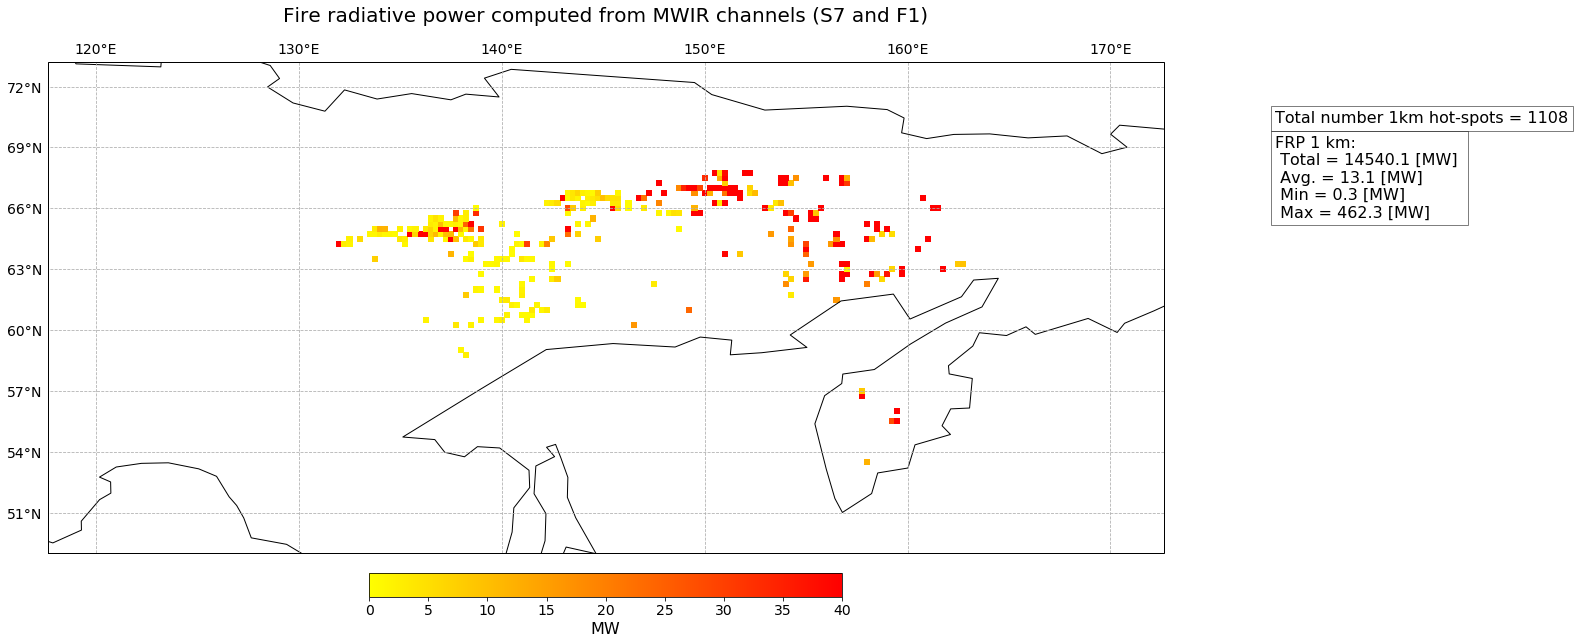

In [22]:
long_name = frp_mwir.long_name
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(D_mwir[:,:],lat_grid, lon_grid, unit, long_name, textstr_1, textstr_2, FRP_plot_max_grid)

<br>

<a href="./00_index.ipynb"><< Index </a><br>
<a href="./12_sentinel3_nrt_slstr_aod_Californian_fires.ipynb"><< 12 - Sentinel-3 NRT SLSTR AOD - Californian Fires </a><span style="float:right;"><a href="./22_sentinel3_nrt_slstr_aod_exercise.ipynb">22 - Sentinel-3 NRT SLSTR AOD - Exercise >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.